## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

## Import Data

In [2]:
data = pd.read_csv('data/sales_train_evaluation.csv')
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [3]:
def events_in_range(data, r):
    x = []; y = []
    for i in range(0,1941,r):
        if (i + r <= 1941):
            x.append(i // r + 1)
            y.append((r - data[i:i+r].count(None)))
    return x, y

## Arrange Data for prediction

In [4]:
N = 1941


## train X and Y have to be declared here

item_id = 'HOBBIES_1_001'
store_id = 'CA_1'
example = data[(data['item_id'] == item_id) & (data['store_id'] == 'CA_1')].to_numpy()[0][6:]
example.size

previous_days = 4
start = 1000

t = np.arange(1000, N, 1).reshape(-1,1)
x1 = np.array([example[i-1] if i - 1 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
x2 = np.array([example[i-2] if i - 2 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
x3 = np.array([example[i-3] if i - 3 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
# np.insert(x1, 1, 4120, axis=0)


y = np.array(example[start:]).reshape(-1,1)
y.size

941

In [5]:
calender = pd.read_csv('data/calendar.csv')
event_calender = calender[['event_name_1', 'event_type_1', 'd']].dropna()

mx = 1941
events = [None] * mx
for index, row  in event_calender.iterrows():
    if int(row['d'][2:]) - 1 <= mx:
        events[int(row['d'][2:]) - 1] = row['event_name_1']
    # print(row['d'])

events_x, events_y = events_in_range(events, 1)
x4 = np.array(events_y[start:]).reshape(-1,1)
x4.shape

(941, 1)

## Sliding Windows Model

In [6]:
# Random Data

# N = 600
# t = np.arange(0, N, 1).reshape(-1,1)
# t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
# t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
# t = np.array(np.round(t, 2))

# x1 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
# x2 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
# x3 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)

# n = np.round((np.random.random(N) * 2).reshape(-1,1), 2)

# y = np.array([((np.log(np.abs(2 + x1[t])) - x2[t-1]**2) + 0.02*x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])
# y = np.round(y+n, 2)

In [7]:
dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, x4, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'x4', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

,t,∆t,x1,x2,x3,x4,y
0,1000,0,0,0,0,0,2
1,1001,1,2,0,0,0,2
2,1002,1,2,2,0,0,0


In [8]:
dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

,t,∆t,x1,x2,x3,y
0,1000,0,0,0,0,2
1,1001,1,2,0,0,2
2,1002,1,2,2,0,0


In [9]:
class WindowSlider(object):
    
    def __init__(self, window_size = 5):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size=5, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

In [10]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size = 0.2, shuffle = False)

In [11]:
trainset

,t,∆t,x1,x2,x3,y
0,1000,0,0,0,0,2
1,1001,1,2,0,0,2
2,1002,1,2,2,0,0
3,1003,1,0,2,2,1
4,1004,1,1,0,2,1
...,...,...,...,...,...,...
747,1747,1,1,1,0,2
748,1748,1,2,1,1,0
749,1749,1,0,2,1,0
750,1750,1,0,0,2,0


In [12]:
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:], previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:], previous_y=True)

train_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,1.0,2.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,5.0,0.0
1,0.0,1.0,2.0,3.0,4.0,2.0,2.0,0.0,1.0,1.0,...,2.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,5.0,0.0
2,0.0,1.0,2.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,5.0,0.0


In [13]:
# ________________ Y_pred = current Y ________________ 
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods=1)

bl_residuals = bl_y_pred - bl_y
# bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
# print('RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')
## RMSE = 11.28

Time to train = 0 seconds


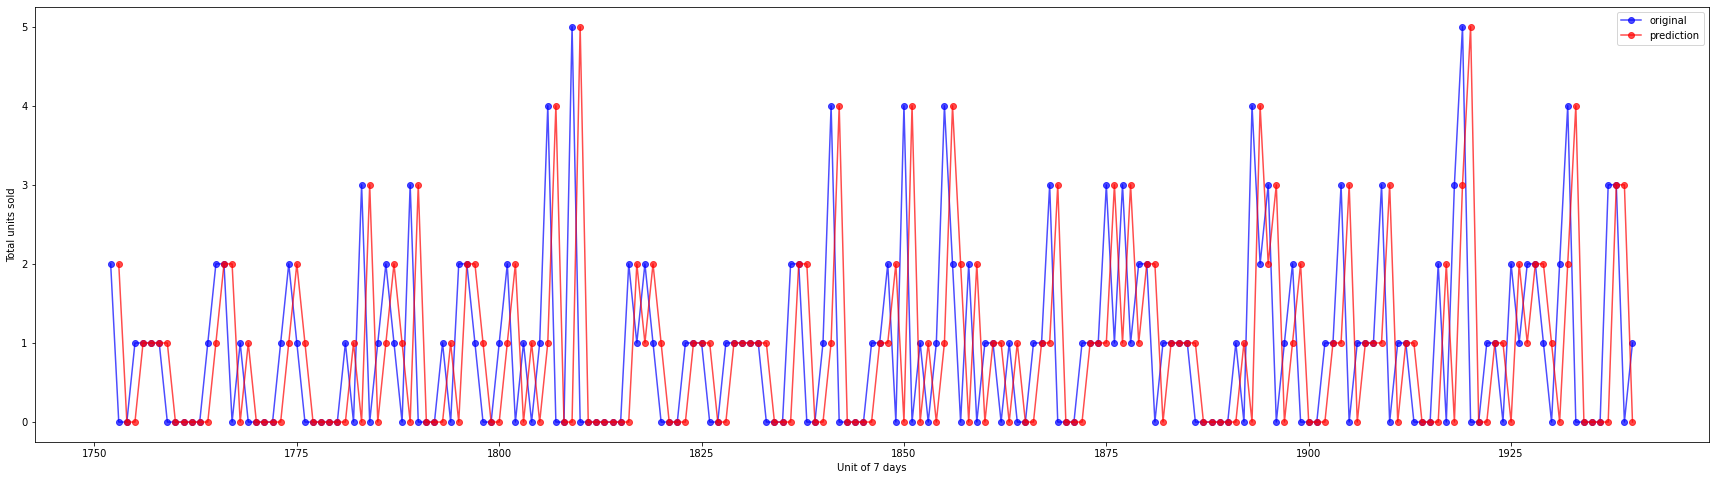

In [14]:
plt.figure(figsize=(30,8))

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'], bl_y_pred, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 7 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [15]:
# ______________ MULTIPLE LINEAR REGRESSION ______________ #
from sklearn.linear_model import LinearRegression
import time
lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
lr_y = testset['y'].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 8.61 
## Time to train = 0.00 seconds

RMSE = 1.16
Time to train = 0.01 seconds


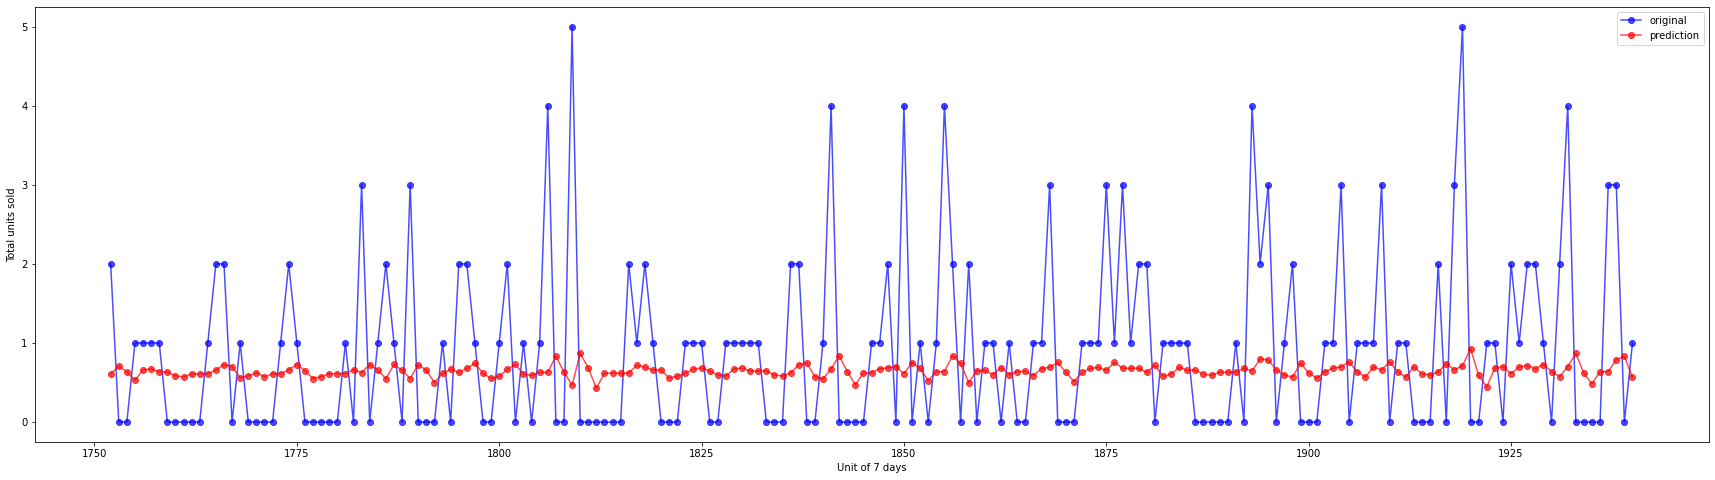

In [16]:
plt.figure(figsize=(30,8))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'], lr_y_pred, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 7 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [17]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y = test_windows['Y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 3.84
## Time to train = 0.00 seconds

RMSE = 1.19
Time to train = 0.09 seconds


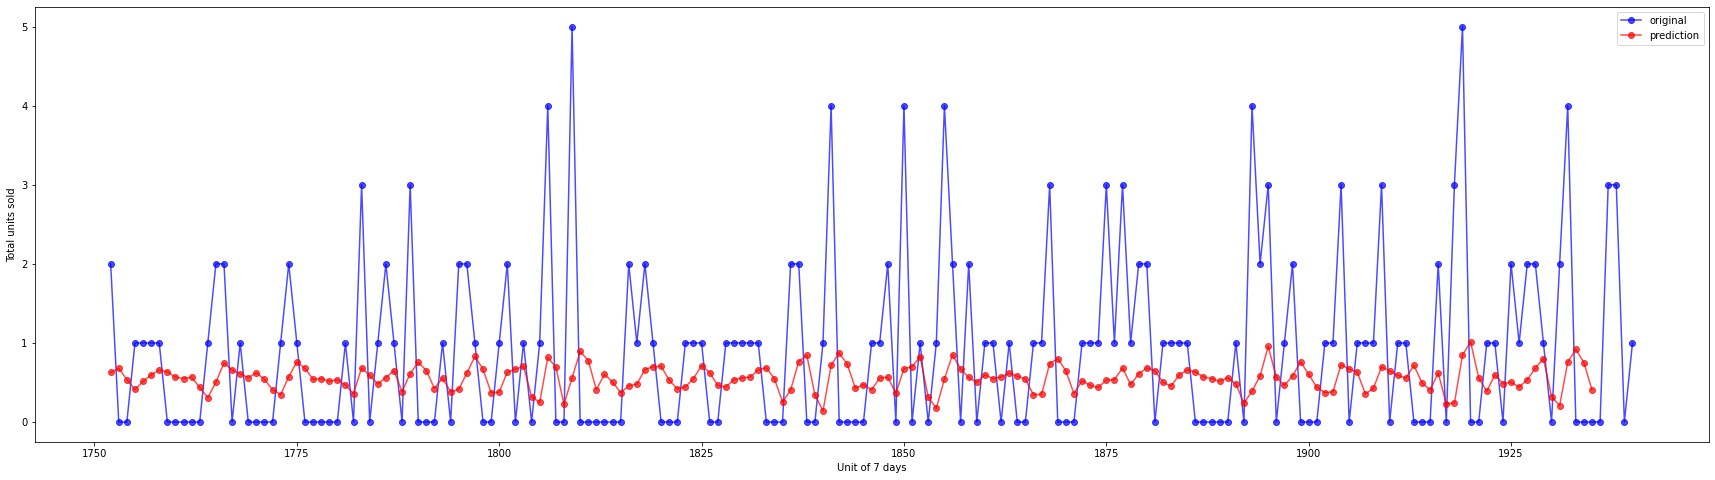

In [19]:
plt.figure(figsize=(30,8))

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][:-5], lr_y_pred, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 7 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [ ]:
test_windows

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,1.0,2.0,3.0,4.0,0.0,2.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,1.0
1,0.0,1.0,2.0,3.0,4.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,5.0,1.0
2,0.0,1.0,2.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,5.0,0.0
3,0.0,1.0,2.0,3.0,4.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,5.0,0.0
4,0.0,1.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.0,1.0,2.0,3.0,4.0,0.0,2.0,4.0,0.0,0.0,...,2.0,4.0,0.0,2.0,1.0,0.0,2.0,4.0,5.0,0.0
180,0.0,1.0,2.0,3.0,4.0,2.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0,5.0,3.0
181,0.0,1.0,2.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,5.0,3.0
182,0.0,1.0,2.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,5.0,0.0


In [21]:
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# It is possible to create custom operations to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
#function_set = ['add', 'sub', 'mul', 'div', 'sin', 'log'] #, xexp]
function_set = ['add', 'sub', 'mul', 'div']

if 'model' in locals(): del model
model = SymbolicRegressor(population_size = 3000, tournament_size=5,
                          generations = 25, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)

###########################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values y
###########################################################

# Train
t0 = time.time()
model.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict
sr_y_fit = model.predict(train_windows.values[:,:-1]).reshape(-1,1)
sr_y_pred = model.predict(test_windows.values[:,:-1]).reshape(-1,1)

# Calculating Errors
sr_residuals = sr_y_pred - testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse = np.sqrt(np.sum(np.power(sr_residuals,2)) / len(sr_residuals))
print('RMSE = %f' % sr_rmse)
print('Time to train %.2f' % (tF - t0))
print(model._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.11          190.039        3          0.80968              N/A      4.37m
   1    10.13          1.91369        3         0.808616              N/A     59.89s
   2     7.36          1.42844        5         0.807389              N/A      1.02m
   3     5.77          1.35967        5         0.807389              N/A     37.61s
   4     5.22          1.46165        5          0.80777              N/A     36.13s
   5     4.46          1.28846        7         0.808212              N/A     32.34s
   6     3.41          1.24966        7         0.808212              N/A     46.22s
   7     2.32          1.17842        3         0.808616              N/A     34.77s
   8     1.65          1.04965        3         0.808613              N/A  

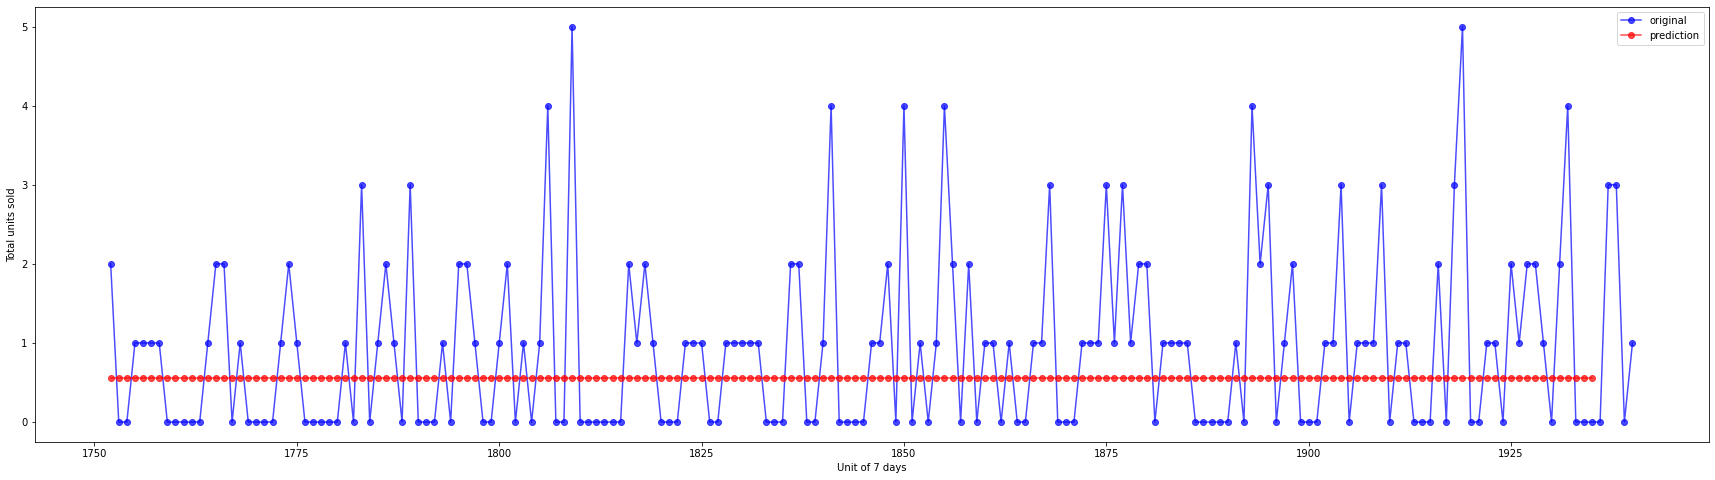

In [23]:
plt.figure(figsize=(30,8))

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][:-5], sr_y_pred, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 7 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()